In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
def create_obs_legend(response):
    data = [[c, k] for k, v in response["observables"].items() for c in v["components"]]
    columns = ["component", "variable"]
    df = pd.DataFrame(data, columns=["component", "variable"]).set_index(columns).sort_index()
    return df


def extract_dataframe(response, key="observables"):
    
    if key == "observables":
        data = {k: v["value"] for k, v in response[key].items()}
    else:
        data = {v["variable"]: v["value"] for v in response[key]}
        
    df = pd.DataFrame(data)
    
    return df

# Параметры модели

In [3]:
r = requests.post("http://127.0.0.1:2021/get_model_params",
                  json={"model_name": "BR"})

In [4]:
params = {k: pd.DataFrame(v).set_index(["component", "variable"])
          for k, v in r.json().items()}

In [5]:
params["params"]

value
component           variable                       
sodium_current      g_Na                    0.04000
                    E_Na                   50.00000
                    g_Nac                   0.00003
stimulus_protocol   IstimStart             10.00000
                    IstimEnd            50000.00000
                    IstimAmplitude          0.50000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
slow_inward_current g_s                     0.00090
membrane            C                       0.01000

In [6]:
params["states"]

,,value
component,variable,
slow_inward_current_d_gate,d,0.0030
slow_inward_current_f_gate,f,0.9940
slow_inward_current,Cai,0.0001
time_dependent_outward_current_x1_gate,x1,0.0001
sodium_current_m_gate,m,0.0110
sodium_current_h_gate,h,0.9880
membrane,V,-84.6240
sodium_current_j_gate,j,0.9750


# Возбудимость

## Пороговый потенциал

In [7]:
p = params["params"].copy()
p.loc[("stimulus_protocol", "IstimAmplitude")] = 0.
p

value
component           variable                       
sodium_current      g_Na                    0.04000
                    E_Na                   50.00000
                    g_Nac                   0.00003
stimulus_protocol   IstimStart             10.00000
                    IstimEnd            50000.00000
                    IstimAmplitude          0.00000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
slow_inward_current g_s                     0.00090
membrane            C                       0.01000

In [8]:
u = params["states"].copy()
u.loc[("membrane", "V")] = -30.
u

,,value
component,variable,
slow_inward_current_d_gate,d,0.0030
slow_inward_current_f_gate,f,0.9940
slow_inward_current,Cai,0.0001
time_dependent_outward_current_x1_gate,x1,0.0001
sodium_current_m_gate,m,0.0110
sodium_current_h_gate,h,0.9880
membrane,V,-30.0000
sodium_current_j_gate,j,0.9750


In [9]:
req_dict = {"model_name": "BR",
            
            "kwargs_problem": {"p": p["value"].to_list(),
                               "u0": u["value"].to_list(),
                               "tspan": [0, 2000]},
            
            "kwargs_solve": {"solver": "CVODE_BDF", "dt": 1e-5, "dtmax": 0.5}}
req_dict

{'model_name': 'BR',
 'kwargs_problem': {'p': [0.04,
   50.0,
   3e-05,
   10.0,
   50000.0,
   0.0,
   1000.0,
   1.0,
   0.0009,
   0.01],
  'u0': [0.003, 0.994, 0.0001, 0.0001, 0.011, 0.988, -30.0, 0.975],
  'tspan': [0, 2000]},
 'kwargs_solve': {'solver': 'CVODE_BDF', 'dt': 1e-05, 'dtmax': 0.5}}

In [10]:
r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
response = r.json()

In [12]:
t = response["time"]
df = extract_dataframe(response, "solution")

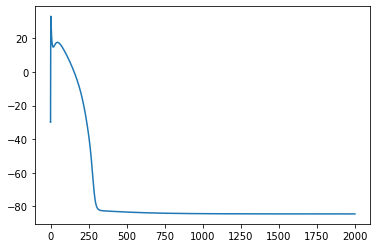

In [13]:
plt.plot(t, df["V"])

### Несколько прогонов с разным V0

In [14]:
V0_array = np.arange(-100, -40, 5)

In [16]:
dfs = []

for V0 in tqdm(V0_array):
    u.loc[("membrane", "V")] = V0
    req_dict["kwargs_problem"]["u0"] = u["value"].to_list()
    
    r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
    response = r.json()
    
    df = extract_dataframe(response, "solution")
    df["t"] = response["time"]
    dfs.append(df)

  0%|          | 0/12 [00:00<?, ?it/s]

Text(0, 0.5, 'V, mV')

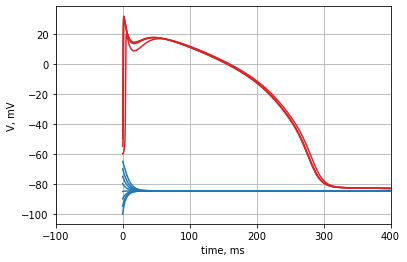

In [17]:
for df, V0 in zip(dfs, V0_array):
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(right=400)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

Text(0, 0.5, 'V, mV')

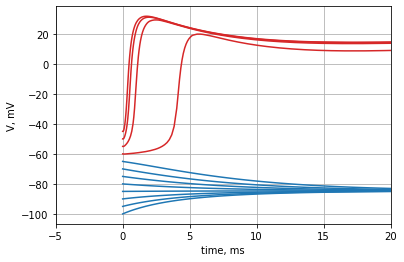

In [18]:
for df, V0 in zip(dfs, V0_array):
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(-5, 20)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

# Istim

## Надпороговый V с разным INa

In [17]:
dfs = []

g_Na_scalers = np.logspace(-1, 0., 10)

u.loc[("membrane", "V")] = -50.
req_dict["kwargs_problem"]["u0"] = u["value"].to_list()
    
for g_Na_scaler in tqdm(g_Na_scalers):
    
    p = params["params"].copy()
    p.loc[("sodium_current", "g_Na")] *= g_Na_scaler
    p.loc[("stimulus_protocol", "IstimAmplitude")] = 0.
    req_dict["kwargs_problem"]["p"] = p["value"].to_list()

    r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
    response = r.json()
    
    df = extract_dataframe(response)
    df["t"] = response["time"]
    dfs.append(df)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'V, mV')

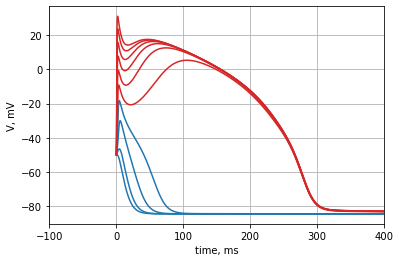

In [18]:
for df in dfs:
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(right=400)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

Text(0, 0.5, 'V, mV')

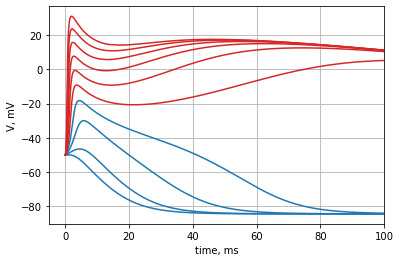

In [19]:
for df in dfs:
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(-5, 100)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

Вставить картинку батон с архитектурой модели

## Надпороговый V с разным IK

In [20]:
dfs = []

scalers = np.logspace(-1, 0., 10)

u.loc[("membrane", "V")] = -50.
req_dict["kwargs_problem"]["u0"] = u["value"].to_list()
    
for scaler in tqdm(scalers):
    
    p = params["params"].copy()
    p.loc[("slow_inward_current", "g_s")] *= scaler
    p.loc[("stimulus_protocol", "IstimAmplitude")] = 0.
    req_dict["kwargs_problem"]["p"] = p["value"].to_list()

    r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
    response = r.json()
    
    df = extract_dataframe(response)
    df["t"] = response["time"]
    dfs.append(df)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'V, mV')

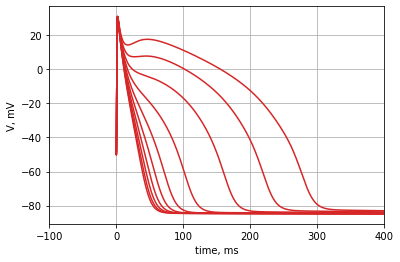

In [21]:
for df in dfs:
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(right=400)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

Text(0, 0.5, 'V, mV')

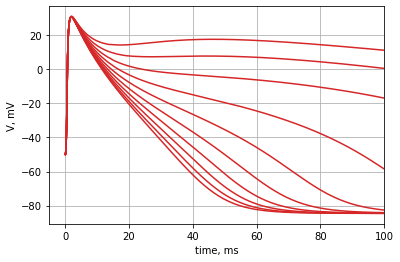

In [22]:
for df in dfs:
    V = df["V"]
    t = df["t"]
    color = "C0" if V.max() < 0 else "C3"
    
    plt.plot(t, V, color=color)
    
plt.xlim(-5, 100)
plt.grid()

plt.xlabel("time, ms")
plt.ylabel("V, mV")

Text(0, 0.5, 'i_K1')

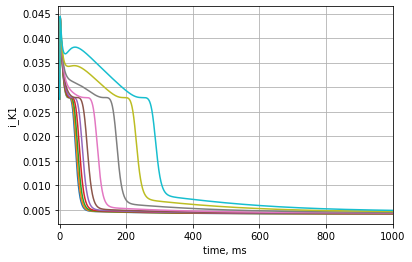

In [23]:
key = "i_K1"

for df in dfs:
    t = df["t"]
    plt.plot(t, df[key])

plt.grid()

plt.xlim(-5, 1000)

plt.xlabel("time, ms")
plt.ylabel(key)

# APD

In [24]:
p = params["params"].copy()
p

value
component           variable                       
sodium_current      g_Na                    0.04000
                    E_Na                   50.00000
                    g_Nac                   0.00003
stimulus_protocol   IstimStart             10.00000
                    IstimEnd            50000.00000
                    IstimAmplitude          0.50000
                    IstimPeriod          1000.00000
                    IstimPulseDuration      1.00000
slow_inward_current g_s                     0.00090
membrane            C                       0.01000

In [66]:
dfs = []

CLs = [2000, 1000, 500, 333, 300, 250]
n_beats = 10

u = params["states"].copy()
u0 = u["value"].to_list()

for CL in tqdm(CLs):

    p = params["params"].copy()
    p.loc[("stimulus_protocol", "IstimPeriod")] = CL
    
    req_dict = {"model_name": "BR",
            
                "kwargs_problem": {"p": p["value"].to_list(),
                                   "u0": u0,
                                   "tspan": [0, n_beats * CL]},

                "kwargs_solve": {"solver": "CVODE_BDF", "dt": 1e-5, "dtmax": 0.5}}
    
    r = requests.post("http://127.0.0.1:2021/solve_problem", json=req_dict)
    response = r.json()
    
    df = extract_dataframe(response, "solution")
    u0 = df.iloc[-1].to_list()
        
    df["t"] = response["time"]
    dfs.append(df)

  0%|          | 0/6 [00:00<?, ?it/s]

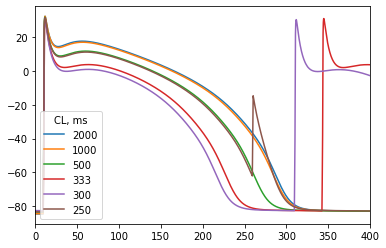

In [71]:
for df, CL in zip(dfs, CLs):
    
    mask_last_beat = df.t > ((n_beats - 2) * CL)
    index_last_depol = (df[mask_last_beat].V > 0).index[0]
    mask_last_beat.loc[:index_last_depol] = False
    
    t = df[mask_last_beat].t.copy()
    t -= t.min()
    
    V = df[mask_last_beat].V
    
    plt.plot(t, V, label=CL)
    
plt.xlim(0, 400)
plt.legend(title="CL, ms")

In [72]:
df_concat = []
t_cum = 0.

for df in dfs:
    df = df.copy()
    df.t += t_cum
    df_concat.append(df)
    t_cum = df.t.iloc[-1]

In [73]:
df_concat = pd.concat(df_concat, ignore_index=True)

(40000.0, 44000.0)

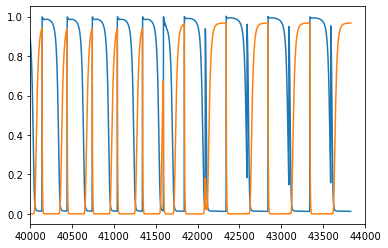

In [80]:
plt.plot(df_concat.t, df_concat.m)
plt.plot(df_concat.t, df_concat.j)
plt.xlim(40_000, 44_000)

2 периода:

~1000

~250

Рефрактерность